# COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [31]:
#see online at https://covid19-jyy3.onrender.com/analysis

In [33]:
#keep repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [34]:
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
plt.style.use('ggplot')

In [35]:
#remove annoying worning about pandas assignment
pd.options.mode.chained_assignment = None

In [36]:
#format x axis with dates
def format_x_date(ax):
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin-1,xmax+1)
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    return xmin,xmax


def lollipop_plot(df, ax, date_col='data', value_col='not_admitted_ratio'):
    #make lollipop
    ax.plot(df[date_col].dt.date, df[value_col], "o",
        markersize=5, color='#007acc', alpha=0.9,label='Ratio')
    #make stick
    ax.vlines(x=df[date_col].dt.date, ymin=0, 
          ymax=df[value_col], color='#007acc', alpha=0.2, linewidth=5)

    #set ticks every week
    xmin,xmax=format_x_date(ax)
    ax.spines['bottom'].set_bounds(xmin+1, xmax-1)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ymin, ymax = ax.get_ylim()
    ax.spines['left'].set_bounds(0, ymax)
    
    return ax

# Load national dataset

In [37]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['ricoverati_con_sintomi_change']=df['ricoverati_con_sintomi']-df['ricoverati_con_sintomi'].shift(1)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
for c in ['nuovi_attualmente_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]:
    
    df[c+'_log']=np.log10(df[c])

## Fig1

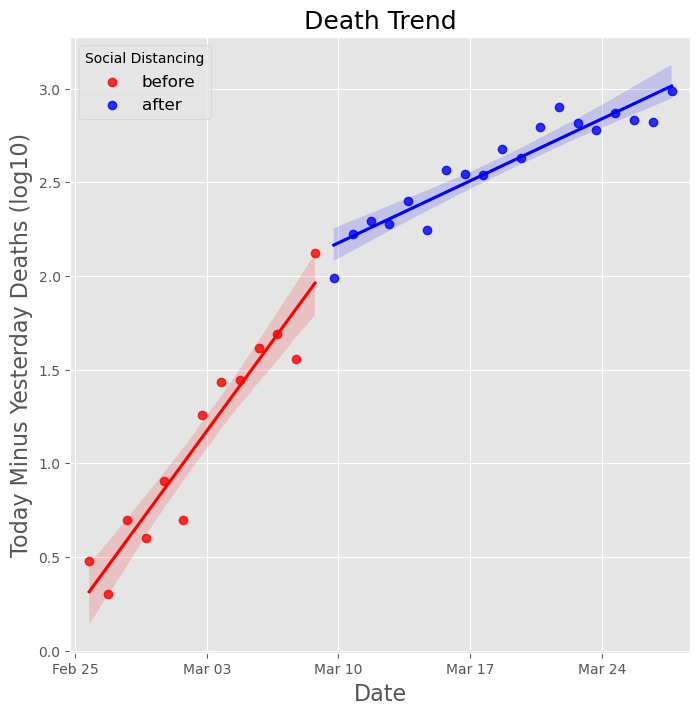

In [38]:
plt.style.use('ggplot')
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[df['data']>'2020-03-9']
after['ndata']=date2num(after['data'])

x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='after')
_,_=format_x_date(ax)
#plt.xticks(rotation=70,ha='right')
plt.xlabel('Date', fontsize='16')
plt.ylabel('Today Minus Yesterday Deaths (log10)',fontsize='16')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Social Distancing',fontsize=12)
plt.savefig('Fig1.png')
plt.show()

## Fig2

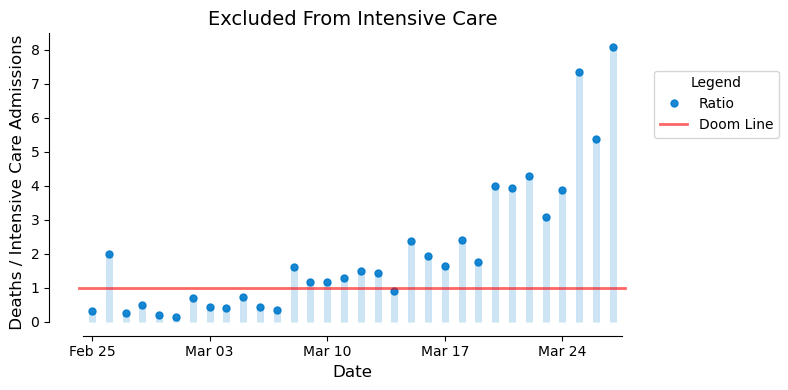

In [39]:
plt.style.use('default')

fig,ax=plt.subplots(figsize=(8,4))

ax = lollipop_plot(df, ax, date_col='data',
                   value_col='not_admitted_ratio')

ax.axhline(1, xmin=0.05,xmax=0.95,
           linewidth=2,color='r',alpha=0.6,label='Doom Line')

plt.xlabel('Date', fontsize='12')
plt.ylabel(' Deaths / Intensive Care Admissions', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.tight_layout()
plt.savefig('Fig2.png')
plt.show()

## Fig3

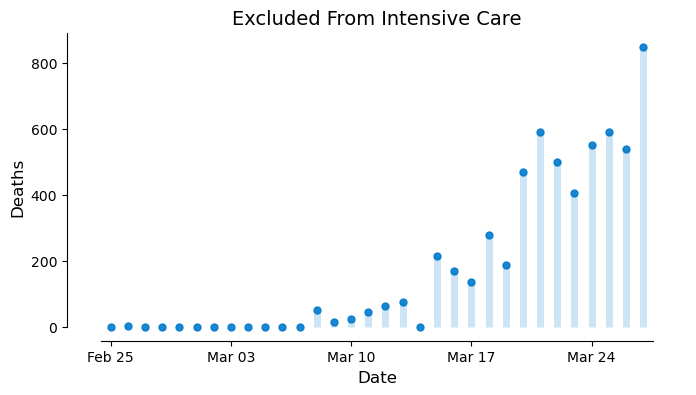

In [40]:
plt.style.use('default')
fig,ax=plt.subplots(figsize=(8,4))
df['not_admitted']=df['not_admitted'].clip(lower=0)
ax = lollipop_plot(df, ax, date_col='data',
                   value_col='not_admitted')

plt.xlabel('Date', fontsize='12')
plt.ylabel('Deaths', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

#plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.savefig('Fig3.png')
plt.show()

In [17]:
!jupyter nbconvert --to html_toc DataVis.ipynb

[NbConvertApp] Converting notebook DataVis.ipynb to html_toc
[NbConvertApp] Support files will be in DataVis_files/
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Writing 305451 bytes to DataVis.html


In [18]:
!git add DataVis*
!git add -u
!git commit -m 'make function for lollipop plot'
!git push -u origin master

[master c2b2010] make function for lollipop plot
 Committer: Michele Tinti <mtinti@ls29490.home>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 4 files changed, 135 insertions(+), 40 deletions(-)
 rewrite DataVis_files/DataVis_8_0.png (97%)
 rewrite Fig1.png (98%)
Counting objects: 7, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 204.82 KiB | 0 bytes/s, done.
Total 7 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/mtinti/COVID-19.git
   fe5d5f6..c2b2010  master -> master
Branch master set up to trac